Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [5]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
tf.keras.layers.LayerNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
## from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.python.keras.utils import np_utils


In [6]:
## Using google drive to mount the data :
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [7]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/gdrive/MyDrive/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2257
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Training the Train dataset here
## Using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6757 files belonging to 9 classes.
Using 5406 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6757 files belonging to 9 classes.
Using 1351 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

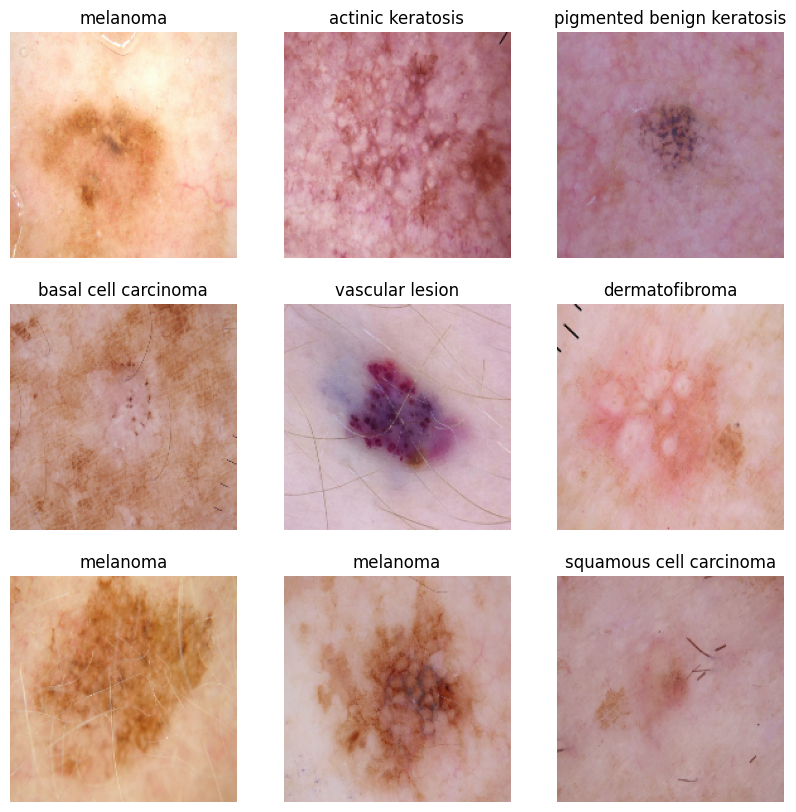

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for img,labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
num_classes = 9

model = Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)

])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 2410s 3s/step - accuracy: 0.2387 - loss: 2.0276 - val_accuracy: 0.4375 - val_loss: 1.4766
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.4720 - loss: 1.4234 - val_accuracy: 0.5352 - val_loss: 1.2433
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5724 - loss: 1.1646 - val_accuracy: 0.6092 - val_loss: 1.0723
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6577 - loss: 0.9494 - val_accuracy: 0.6795 - val_loss: 0.9436
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7420 - loss: 0.7425 - val_accuracy: 0.7069 - val_loss: 0.8409
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7887 - loss: 0.6151 - val_accuracy: 0.7321 - val_loss: 0.7668
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8336 - loss: 0.4531 - val_accuracy: 0.7298 - val_loss: 0.8450
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8905 - loss: 0.3254 - val_ac

### Visualizing training results

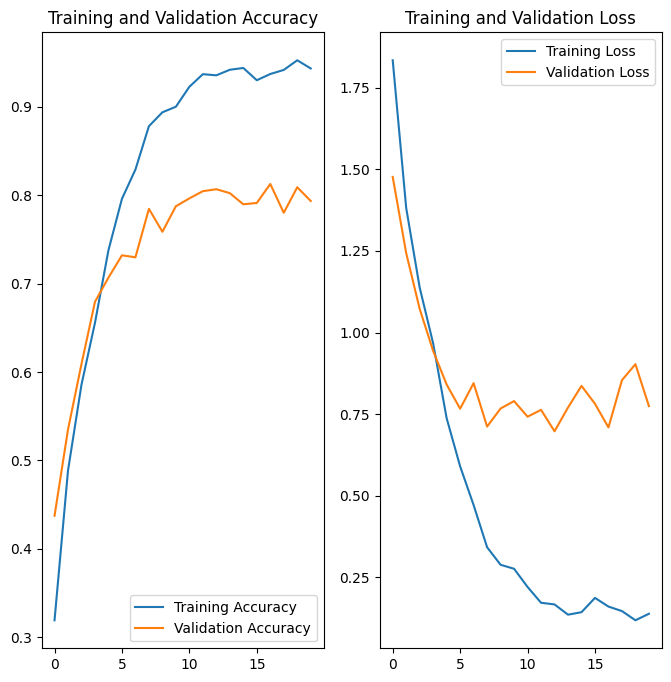

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

**Inference from Model 1:**As we can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 55% accuracy on the validation set.

**Overfitting:** In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy is only around 55% in the training process. This difference is a clear indicator of overfitting

### Write your findings here

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                  input_shape=(img_height,
                  img_width,
                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

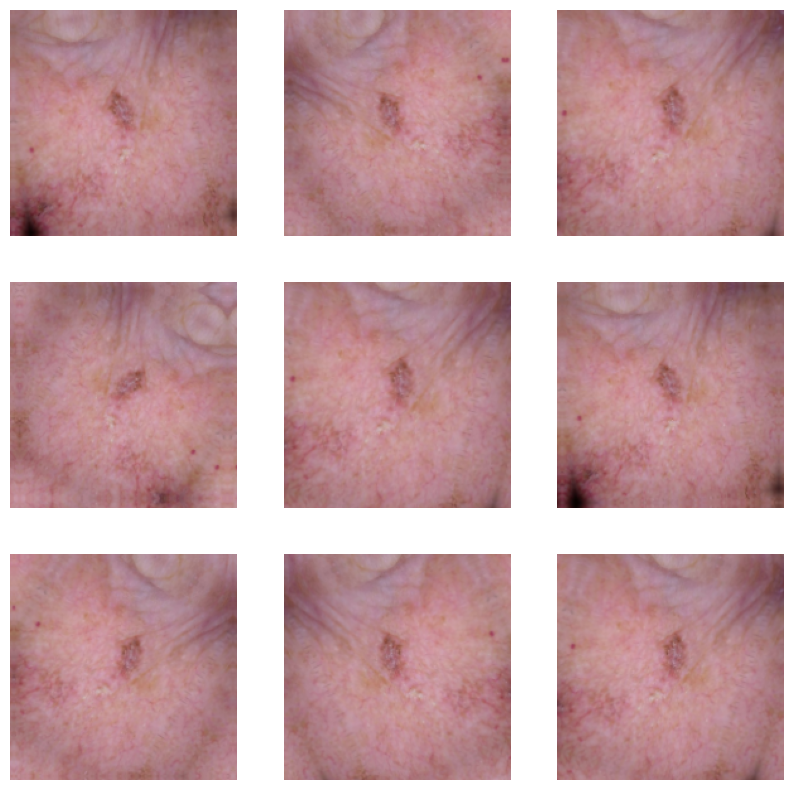

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [25]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.2153 - loss: 2.1039 - val_accuracy: 0.3879 - val_loss: 1.5915
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.3991 - loss: 1.5457 - val_accuracy: 0.4634 - val_loss: 1.4236
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4606 - loss: 1.4067 - val_accuracy: 0.4789 - val_loss: 1.3482
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5008 - loss: 1.3231 - val_accuracy: 0.5056 - val_loss: 1.3081
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5028 - loss: 1.2751 - val_accuracy: 0.5292 - val_loss: 1.2506
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5538 - loss: 1.1728 - val_accuracy: 0.5514 - val_loss: 1.1620
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5453 - loss: 1.1971 - val_accuracy: 0.6062 - val_loss: 1.0967
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5633 - loss: 1.1308 - val_acc

### Visualizing the results

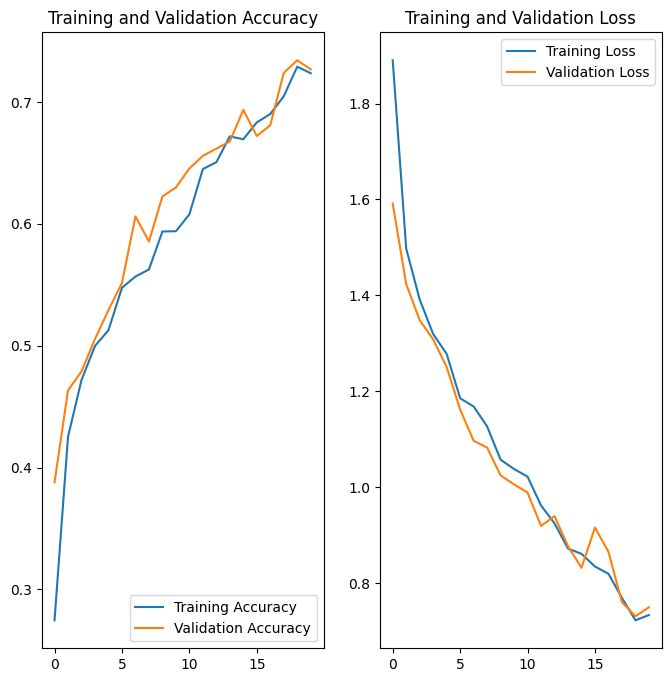

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

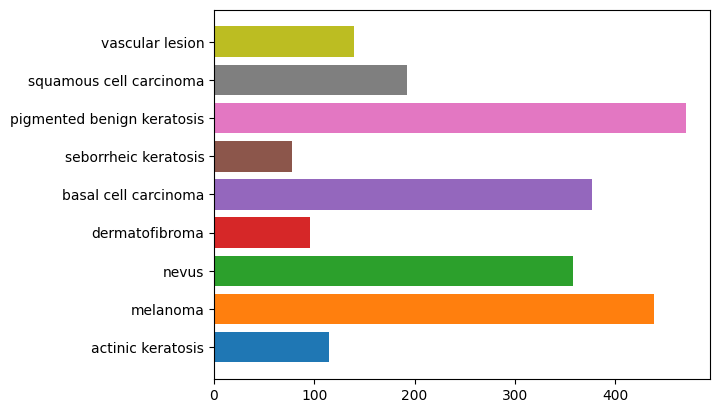

In [27]:
from pathlib import Path

import os
path = '/content/gdrive/MyDrive/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
mn = 0
folders = ([name for name in os.listdir(path)
            if os.path.isdir(os.path.join(path, name))]) # get all directories
for folder in folders:
    contents = os.listdir(os.path.join(path,folder)) # get list of contents
    if len(contents) >= mn: # if greater than the limit, print folder and number of contents
        plt.barh(folder,len(contents))

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### ***ANS - Seborrheic Keratosis has the least number of samples.***
#### - Which classes dominate the data in terms proportionate number of samples?
#### ***ANS - Pigmented Benign Keratosis dominates the data in terms of number of samples.***


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

In [29]:
path_to_training_dataset = '/content/gdrive/MyDrive/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration'
path_to_training_dataset = path_to_training_dataset + "/Train"
print(path_to_training_dataset)


/content/gdrive/MyDrive/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8880A73730>: 100%|██████████| 500/500 [00:24<00:00, 20.16 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8880AC3B20>: 100%|██████████| 500/500 [00:22<00:00, 22.20 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8880A11F60>: 100%|██████████| 500/500 [00:21<00:00, 23.73 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8880A8FA30>: 100%|██████████| 500/500 [01:26<00:00,  5.77 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8880A22800>: 100%|██████████| 500/500 [01:12<00:00,  6.86 Samples/s]


Initialised with 470 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F888091BAF0>: 100%|██████████| 500/500 [00:18<00:00, 26.42 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8880A33DF0>: 100%|██████████| 500/500 [00:42<00:00, 11.70 Samples/s]


Initialised with 191 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8880A34EE0>: 100%|██████████| 500/500 [00:19<00:00, 25.97 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8880A060B0>: 100%|██████████| 500/500 [00:20<00:00, 24.46 Samples/s]


In [31]:
data_dir_train = pathlib.Path(path_to_training_dataset)

In [32]:
print(data_dir_train)

/content/gdrive/MyDrive/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
import glob
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030143.jpg_21668fa1-5ea3-4cfd-b35a-badb79ffb4ee.jpg',
 '/content/gdrive/MyDrive/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026468.jpg_edceb1ac-96cf-4eda-bd11-ff62b84cd6c3.jpg',
 '/content/gdrive/MyDrive/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027562.jpg_753956ff-c739-493a-9466-e62e4765cbfe.jpg',
 '/content/gdrive/MyDrive/Melanoma Detection assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031335.jpg_52201c3e-fa00-4547-be31-f54960ca2985.jpg',
 '/content/gdrive/MyDrive/Melanoma Detection assignment/

In [37]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [39]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesson_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesson_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)


In [40]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,1470
melanoma,1438
basal cell carcinoma,1376
nevus,1357
squamous cell carcinoma,1191
vascular lesion,1139
actinic keratosis,1114
dermatofibroma,1095
seborrheic keratosis,1077


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [42]:
data_dir_train= os.path.join(data_dir_train)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size = (img_height, img_width),
  batch_size = batch_size
  )

Found 11257 files belonging to 9 classes.
Using 9006 files for training.


#### **Todo:** Create a validation dataset

In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11257 files belonging to 9 classes.
Using 2251 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [47]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [48]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [49]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 66s 229ms/step - accuracy: 0.7172 - loss: 0.7608 - val_accuracy: 0.7494 - val_loss: 0.6870
Epoch 2/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 78s 216ms/step - accuracy: 0.7463 - loss: 0.6829 - val_accuracy: 0.6970 - val_loss: 0.8181
Epoch 3/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 215ms/step - accuracy: 0.7481 - loss: 0.6748 - val_accuracy: 0.7601 - val_loss: 0.6490
Epoch 4/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 214ms/step - accuracy: 0.7707 - loss: 0.6358 - val_accuracy: 0.7996 - val_loss: 0.5525
Epoch 5/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 61s 217ms/step - accuracy: 0.7783 - loss: 0.6023 - val_accuracy: 0.7801 - val_loss: 0.5939
Epoch 6/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - accuracy: 0.7803 - loss: 0.6006 - val_accuracy: 0.7805 - val_loss: 0.6039
Epoch 7/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 220ms/step - accuracy: 0.7919 - loss: 0.5706 - val_accuracy: 0.7925 - val_loss: 0.5556
Epoch 8/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 221ms/step - accuracy: 0.8013 - loss: 0

#### **Todo:**  Visualize the model results

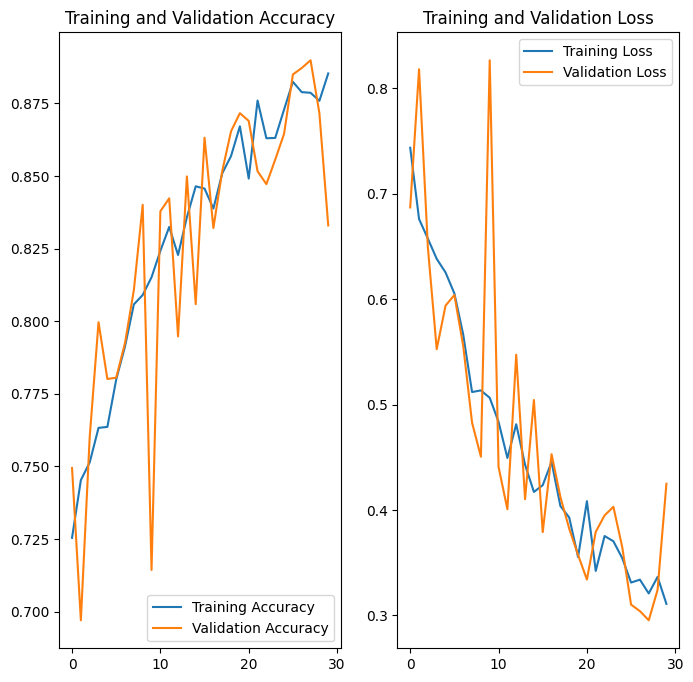

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Inference from Model 3:**

The above results in graph and training data indicate that the accuracy has improved and that there is no overfitting of the model. Class rebalancing helped to increse the accuracy significantly.